## Imports

In [4]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn')

In [5]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.utils import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping

## Data Loading and Exploration

In [8]:
df_article = pd.read_csv('data-newspaper.csv')
df_article.head()

,article_id,article_topic,article_content
0,93205794,Internasional,Kepolisian Inggris tengah memburu pelaku yang...
1,93186698,Ekonomi,Seluruh layanan transaksi di jalan tol akan m...
2,93191463,Teknologi,"\nHari ini, Rabu (23/8), ternyata menjadi har..."
3,93219292,Ekonomi,Saat ini Indonesia hanya memiliki cadangan ba...
4,343106,Hiburan,"Hari ini, Selasa (1/8), pedangdut Ridho Rhoma..."


In [9]:
df_article.tail()

,article_id,article_topic,article_content
9995,93221319,Bojonegoro,Reporter : Joel JokoblokBojonegoro.com - Har...
9996,93203115,Ekonomi,"Pada akhir tahun ini, Direktur Jenderal (Dirj..."
9997,93230854,Sepak Bola,Ketika pertama kali datang ke Barcelona pada ...
9998,93199312,Sepak Bola,Tim Nasional (Timnas) Indonesia U-19 berhasil...
9999,93194682,Teknologi,Telkom masih melakukan proses perbaikan dan p...


In [10]:
topics = df_article['article_topic'].unique()

In [11]:
len(topics)

29

In [12]:
df_article['article_topic'][0]

'Internasional'

In [13]:
df_article['article_content'][0]

' Kepolisian Inggris tengah memburu pelaku yang meledakkan bom di stasiun London. Sedikitnya 22 orang terluka dalam peristiwa yang terjadi pada Jumat pagi yang sibuk (15/9).Menurut asisten komisaris kepolisian Inggris Mark Rowley seperti dikutip The Guardian, ratusan detektif dikerahkan untuk menyelidiki kasus ini. Mereka akan memeriksa semua rekaman CCTV di jaringan kereta bawah tanah London untuk mencari pelakunya.Sebelumnya kepolisian telah menangani kasus ini sebagai aksi terorisme. Penyelidikan juga dilakukan oleh Komando Pemberantasan Terorisme Kepolisian London dan badan keamanan dalam negeri Inggris MI5.Ledakan terjadi di stasiun Parsons Green di salam satu gerbong kereta. Peristiwa ini memicu kepanikan ratusan penumpang yang langsung berhamburan menyelamatkan diri. Sedikitnya 22 orang terluka, namun tidak mengancam nyawa.Menurut kepolisian, bom rakitan itu belum sepenuhnya meledak. Tim forensik akan menyelidiki bom itu, mencari tahu bahan kimia yang digunakan, dan dari mana pe

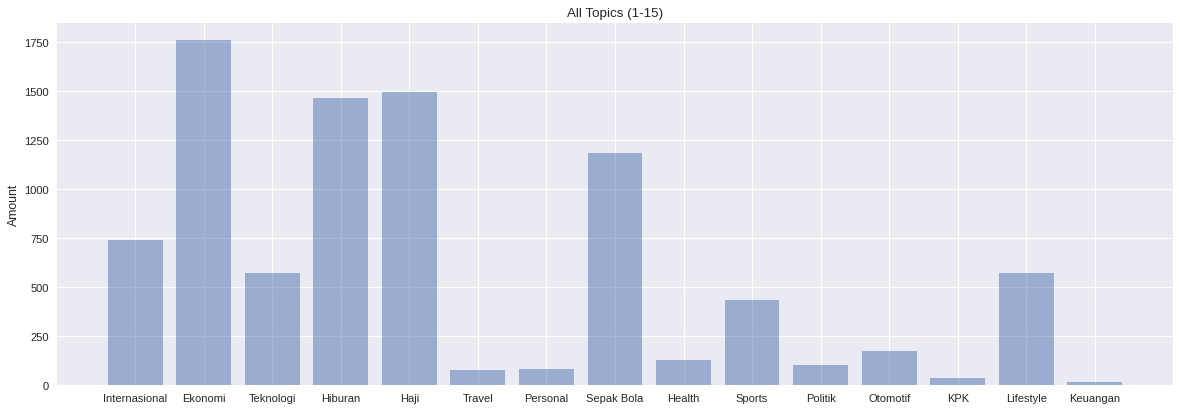

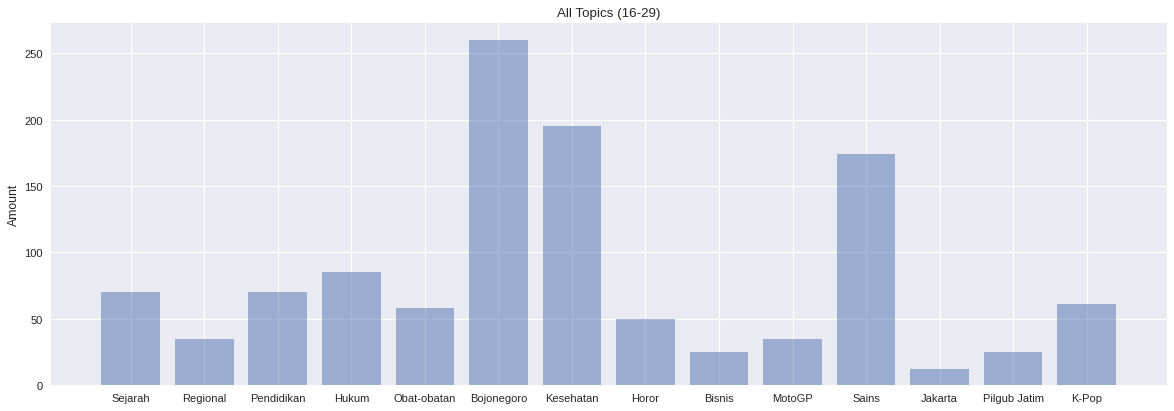

In [14]:
objects = df_article['article_topic'].unique()
y_pos = np.arange(len(objects))
performance = [len(df_article[df_article['article_topic'] == topic]) for topic in objects]

plt.figure(figsize=(18, 6), dpi=80)
plt.bar(y_pos[:15], performance[:15], align='center', alpha=0.5)
plt.xticks(y_pos[:15], objects[:15])
plt.ylabel('Amount')
plt.title('All Topics (1-15)')

plt.show()

plt.figure(figsize=(18, 6), dpi=80)
plt.bar(y_pos[15:], performance[15:], align='center', alpha=0.5)
plt.xticks(y_pos[15:], objects[15:])
plt.ylabel('Amount')
plt.title('All Topics (16-29)')

plt.show()

Our dataset is quite imbalanced for some classes, that have very small sample size. This may cause mispredictions for those classes.

## Text Preprocessing

**Drop unnecessary columns**

In [15]:
df_article.drop('article_id', axis=1, inplace=True)

**Drop Null Values**

In [16]:
df_article.isnull().any()

article_topic      False
article_content     True
dtype: bool

In [17]:
df_article['article_content'].isnull().sum()

36

In [18]:
print(df_article[df_article['article_content'].isnull()])

      article_topic article_content
197       Teknologi             NaN
674         Hiburan             NaN
817         Hiburan             NaN
972        Otomotif             NaN
2015        Hiburan             NaN
2250        Hiburan             NaN
3276      Teknologi             NaN
4150        Hiburan             NaN
4338     Sepak Bola             NaN
4750     Sepak Bola             NaN
4838        Politik             NaN
4917        Hiburan             NaN
5126        Hiburan             NaN
5306      Lifestyle             NaN
5859        Hiburan             NaN
5965      Lifestyle             NaN
6032  Internasional             NaN
6094        Hiburan             NaN
6442        Ekonomi             NaN
6539      Lifestyle             NaN
6689        Hiburan             NaN
6760        Hiburan             NaN
6816  Internasional             NaN
6886     Sepak Bola             NaN
7239        Hiburan             NaN
7307        Hiburan             NaN
7403        Hiburan         

In [19]:
df_article.dropna(inplace=True)
df_article.reset_index(inplace=True)
df_article.drop('index', axis=1, inplace=True)

In [20]:
df_article.tail()

,article_topic,article_content
9959,Bojonegoro,Reporter : Joel JokoblokBojonegoro.com - Har...
9960,Ekonomi,"Pada akhir tahun ini, Direktur Jenderal (Dirj..."
9961,Sepak Bola,Ketika pertama kali datang ke Barcelona pada ...
9962,Sepak Bola,Tim Nasional (Timnas) Indonesia U-19 berhasil...
9963,Teknologi,Telkom masih melakukan proses perbaikan dan p...


In [21]:
articles = df_article['article_content'].to_numpy()

In [22]:
stop_words = list(set(stopwords.words('indonesian')))

In [23]:
print(len(stop_words))

757


In [24]:
def clean(string):
  lower_case = string.lower() # 1. Turn into Lowercase
  # 2. Remove Unessecary Symbols
  text = re.sub('<.*?>', '', lower_case) #HTML tags
  text = re.sub('\S*@\S*\s?', '', text) #Emails
  text = re.sub("http[s]?\://\S+", '', text) #URLs
  text = re.sub("\d", '', text) #Numbers
  text = re.sub('[^\w\s]', '', text) #Punctuations
  # 3. Tokenize Words
  word_tokens = word_tokenize(text)
  # 4. Remove Stopwords
  filtered_sentence = []
  for word in word_tokens:
    if word not in stop_words:
      filtered_sentence.append(word)
  
  # Join words to a String
  return ' '.join(filtered_sentence)

In [25]:
clean(df_article['article_content'][0])

'kepolisian inggris memburu pelaku meledakkan bom stasiun london orang terluka peristiwa jumat pagi sibuk asisten komisaris kepolisian inggris mark rowley dikutip the guardian ratusan detektif dikerahkan menyelidiki memeriksa rekaman cctv jaringan kereta tanah london mencari pelakunyasebelumnya kepolisian menangani aksi terorisme penyelidikan komando pemberantasan terorisme kepolisian london badan keamanan negeri inggris miledakan stasiun parsons green salam gerbong kereta peristiwa memicu kepanikan ratusan penumpang langsung berhamburan menyelamatkan orang terluka mengancam nyawamenurut kepolisian bom rakitan sepenuhnya meledak tim forensik menyelidiki bom mencari bahan kimia pelaku mempelajari pembuatannyainggris mengalami kali serangan teroris menewaskan orang orang tewas ledakan bunuh kereta tanah london bus'

In [26]:
cleaned_articles = []
for text in articles:
  cleaned_articles.append(clean(text))
cleaned_articles = np.array(cleaned_articles)

In [27]:
# Create vocabulary dict consisting of vocab mapped with index
tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleaned_articles)

In [28]:
print(tokenizer.word_index)

{'indonesia': 1, 'haji': 2, 'jemaah': 3, 'orang': 4, 'rp': 5, 'memiliki': 6, 'pemain': 7, 'salah': 8, 'wafat': 9, 'usia': 10, 'jakarta': 11, 'kali': 12, 'gol': 13, 'dunia': 14, 'agustus': 15, 'pemerintah': 16, 'negara': 17, 'laga': 18, 'september': 19, 'tim': 20, 'rumah': 21, 'langsung': 22, 'makkah': 23, 'musim': 24, 'anak': 25, 'gangguan': 26, 'berhasil': 27, 'jamaah': 28, 'ya': 29, 'jantung': 30, 'masyarakat': 31, 'as': 32, 'air': 33, 'juta': 34, 'kloter': 35, 'kota': 36, 'harga': 37, 'darah': 38, 'saudi': 39, 'nama': 40, 'menit': 41, 'bin': 42, 'masuk': 43, 'the': 44, 'film': 45, 'bola': 46, 'dana': 47, 'pertandingan': 48, 'perusahaan': 49, 'madinah': 50, 'mengalami': 51, 'penyakit': 52, 'persen': 53, 'pt': 54, 'hasil': 55, 'proses': 56, 'arab': 57, 'poin': 58, 'uang': 59, 'mencapai': 60, 'kesehatan': 61, 'terkait': 62, 'bermain': 63, 'kondisi': 64, 'acara': 65, 'jalan': 66, 'calon': 67, 'tanah': 68, 'serangan': 69, 'sakit': 70, 'kementerian': 71, 'posisi': 72, 'kerja': 73, 'kepala

In [29]:
len(tokenizer.word_index)

130920

In [30]:
encoded_articles = tokenizer.texts_to_sequences(cleaned_articles)
encoded_articles = np.array(encoded_articles)

In [31]:
print(cleaned_articles[0])
print(encoded_articles[0])

kepolisian inggris memburu pelaku meledakkan bom stasiun london orang terluka peristiwa jumat pagi sibuk asisten komisaris kepolisian inggris mark rowley dikutip the guardian ratusan detektif dikerahkan menyelidiki memeriksa rekaman cctv jaringan kereta tanah london mencari pelakunyasebelumnya kepolisian menangani aksi terorisme penyelidikan komando pemberantasan terorisme kepolisian london badan keamanan negeri inggris miledakan stasiun parsons green salam gerbong kereta peristiwa memicu kepanikan ratusan penumpang langsung berhamburan menyelamatkan orang terluka mengancam nyawamenurut kepolisian bom rakitan sepenuhnya meledak tim forensik menyelidiki bom mencari bahan kimia pelaku mempelajari pembuatannyainggris mengalami kali serangan teroris menewaskan orang orang tewas ledakan bunuh kereta tanah london bus
[795, 262, 5070, 321, 14200, 1713, 1155, 1343, 4, 2499, 1102, 131, 271, 2209, 2253, 2937, 795, 262, 4012, 39140, 558, 44, 4013, 970, 21296, 8382, 5646, 3057, 2362, 5647, 535, 74

Every word is represented by an integer that corresponds to the index of that word in the vocabulary dictionary.

In [32]:
print(len(cleaned_articles[0].split()))
print(len(encoded_articles[0]))

98
98


In [33]:
lengths = []
for article in encoded_articles:
  lengths.append(len(article))

print(np.mean(np.array(lengths)))

198.80820955439583


Most of the articles have a length of between 0-400 words.

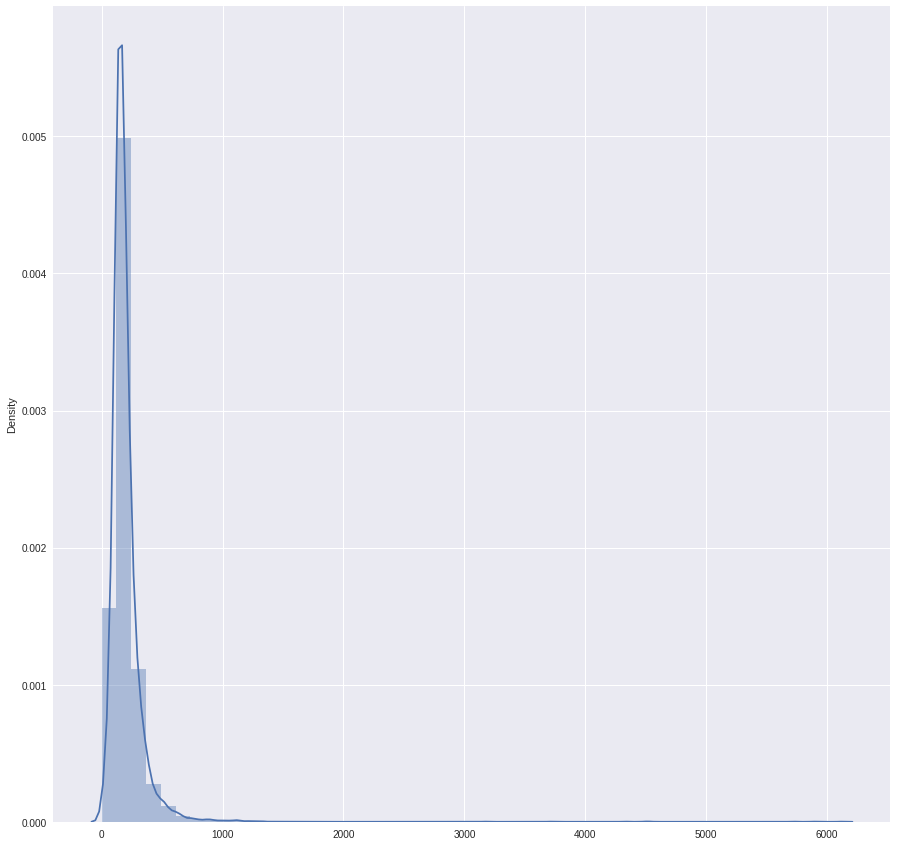

In [34]:
plt.figure(figsize=(15,15))
sns.distplot(lengths)
plt.show()

Add zero padding for articles below a length of 300 words, and truncate articles over 300 words.

In [35]:
padded_articles = pad_sequences(encoded_articles, maxlen=300, padding='post', truncating='post')

In [36]:
print(padded_articles[0])

[  795   262  5070   321 14200  1713  1155  1343     4  2499  1102   131
   271  2209  2253  2937   795   262  4012 39140   558    44  4013   970
 21296  8382  5646  3057  2362  5647   535   740    68  1343   277 52799
   795  1720   268  2500  2721  5828  3302  2500   795  1343   167   427
   100   262 52800  1155 15598  2860  4362  8983   740  1102  1368  9421
   970   703    22 16459  2254     4  2499  1751 39141   795  1713 14868
  1663  5347    20 21297  5646  1713   277   219  1517   321  3864 52801
    51    12    69  3009  2383     4     4   796  3198  2011   740    68
  1343   249     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

## Label Preprocessing

In [37]:
topics = df_article['article_topic'].to_numpy()

Adapt to Sklearn OneHotEncoder input shape

In [38]:
topics = topics[:, np.newaxis]

In [39]:
print(topics.shape)

(9964, 1)


In [40]:
one_hot_encoder = OneHotEncoder(sparse=False)
encoded_labels = one_hot_encoder.fit_transform(topics)

In [41]:
print(encoded_labels.shape)

(9964, 29)


In [42]:
print(encoded_labels[0])

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]


## Model Training

Stratify tries to help with balancing the samples between train and test set.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(padded_articles, encoded_labels, test_size=0.2, random_state=8, stratify=encoded_labels)

Hyperparameter Experiments regarding vector_size, LSTM neurons, dropout layer, etc.

In [83]:
model = Sequential()
# Word2Vec layer, having input dimensions from number of vocabs, and input_length from padding max length, output dim is vector size
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=120, input_length=300))
# Try add dropout layer to prevent overfitting in loss metric.
model.add(Dropout(0.2))
# NLP Crucial Layer to read text sequence. 
model.add(LSTM(200))
# Regular Dense Layer for Output Prediction
model.add(Dense(29, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [84]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 120)          15710520  
                                                                 
 dropout_2 (Dropout)         (None, 300, 120)          0         
                                                                 
 lstm_2 (LSTM)               (None, 200)               256800    
                                                                 
 dense_2 (Dense)             (None, 29)                5829      
                                                                 
Total params: 15,973,149
Trainable params: 15,973,149
Non-trainable params: 0
_________________________________________________________________


Stop training if validation accuracy reach convergence. In that area of convergence, extract the model with minimum loss.

In [85]:
mc = ModelCheckpoint(filepath="model.h5", monitor="val_loss", mode="min", save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max')

Experiment with batch_size.

In [86]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32, callbacks=[mc, es])

Epoch 1/30
250/250 [==============================] - ETA: 0s - loss: 2.6072 - accuracy: 0.1745
Epoch 1: val_loss improved from inf to 2.49753, saving model to model.h5
250/250 [==============================] - 12s 40ms/step - loss: 2.6072 - accuracy: 0.1745 - val_loss: 2.4975 - val_accuracy: 0.2168
Epoch 2/30
249/250 [============================>.] - ETA: 0s - loss: 2.4022 - accuracy: 0.2323
Epoch 2: val_loss improved from 2.49753 to 2.36554, saving model to model.h5
250/250 [==============================] - 9s 35ms/step - loss: 2.4021 - accuracy: 0.2323 - val_loss: 2.3655 - val_accuracy: 0.2418
Epoch 3/30
249/250 [============================>.] - ETA: 0s - loss: 2.3738 - accuracy: 0.2368
Epoch 3: val_loss did not improve from 2.36554
250/250 [==============================] - 8s 32ms/step - loss: 2.3736 - accuracy: 0.2369 - val_loss: 2.4170 - val_accuracy: 0.2659
Epoch 4/30
249/250 [============================>.] - ETA: 0s - loss: 2.2920 - accuracy: 0.2823
Epoch 4: val_loss impr

## Model Evaluation

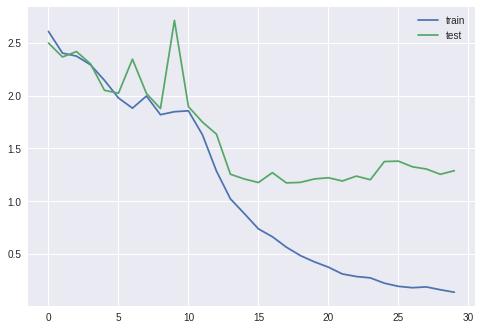

In [87]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.savefig('Loss Graph')
plt.show()

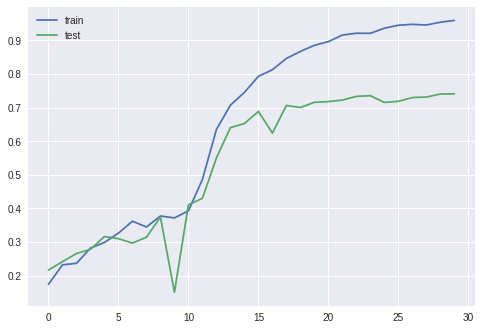

In [88]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.savefig('Accuracy Graph')
plt.show()

In [89]:
h5model = load_model('model.h5')

In [90]:
loss, acc = h5model.evaluate(X_test, y_test, verbose=False)
print('Validation Accuracy: ', np.round(acc*100, 2), '%')
print('Validation Loss: ', np.round(loss, 2))

Validation Accuracy:  70.6 %
Validation Loss:  1.17


In [91]:
labels = [label.split('_')[1] for label in one_hot_encoder.get_feature_names()]
print(labels)

['Bisnis', 'Bojonegoro', 'Ekonomi', 'Haji', 'Health', 'Hiburan', 'Horor', 'Hukum', 'Internasional', 'Jakarta', 'K-Pop', 'KPK', 'Kesehatan', 'Keuangan', 'Lifestyle', 'MotoGP', 'Obat-obatan', 'Otomotif', 'Pendidikan', 'Personal', 'Pilgub Jatim', 'Politik', 'Regional', 'Sains', 'Sejarah', 'Sepak Bola', 'Sports', 'Teknologi', 'Travel']


In [92]:
y_predictions = h5model.predict(X_test)

63/63 [==============================] - 1s 8ms/step


Classification Report function only accepts 1D array, so turn one-hot encoding into label encoding.

In [93]:
y_pred_evaluate = np.argmax(y_predictions, axis=1)
y_test_evaluate = np.argmax(y_test, axis=1)

In [94]:
print(classification_report(y_test_evaluate, y_pred_evaluate, target_names = labels))
print('Weighted F1 Score: ', f1_score(y_test_evaluate, y_pred_evaluate, average='weighted'))

               precision    recall  f1-score   support

       Bisnis       0.00      0.00      0.00         5
   Bojonegoro       0.21      0.19      0.20        52
      Ekonomi       0.92      0.88      0.90       352
         Haji       0.96      0.95      0.95       299
       Health       0.38      0.12      0.18        26
      Hiburan       0.84      0.87      0.85       290
        Horor       0.00      0.00      0.00        10
        Hukum       0.00      0.00      0.00        17
Internasional       0.38      0.72      0.50       148
      Jakarta       0.00      0.00      0.00         2
        K-Pop       0.00      0.00      0.00        12
          KPK       1.00      0.43      0.60         7
    Kesehatan       0.47      0.51      0.49        39
     Keuangan       0.00      0.00      0.00         3
    Lifestyle       0.60      0.67      0.63       114
       MotoGP       0.00      0.00      0.00         7
  Obat-obatan       0.33      0.08      0.13        12
     Otom

Get weighted avg score instead of macro avg score, because our dataset is imbalanced. Weighted avg score takes into account the sample size for each class.

## Model Testing

In [95]:
# Create a new string 
string = '''
Menurut Tafsir Kementerian Agama RI, surat Al Hajj ayat 27 mengandung perintah Allah SWT kepada Nabi Ibrahim AS agar menyeru manusia untuk mengerjakan ibadah haji ke Baitullah dan menyampaikan kepada mereka bahwa haji termasuk ibadah wajib bagi muslimin.

Baca artikel detikhikmah, "Surat Al Hajj Ayat 27: Perintah untuk Menunaikan Haji" selengkapnya https://www.detik.com/hikmah/khazanah/d-6458426/surat-al-hajj-ayat-27-perintah-untuk-menunaikan-haji.

Download Apps Detikcom Sekarang https://apps.detik.com/detik/
'''

In [96]:
# Clean the new string
cleaned_string = clean(string)
print(cleaned_string)

# Encode all words in the string
encoded_string = tokenizer.texts_to_sequences([cleaned_string])

# Add zero padding such that the string will be having the length of 300 words
padded_string = pad_sequences(encoded_string, maxlen=300)

tafsir kementerian agama ri surat al hajj ayat mengandung perintah allah swt nabi ibrahim as menyeru manusia ibadah haji baitullah haji ibadah wajib muslimin baca artikel detikhikmah surat al hajj ayat perintah menunaikan haji selengkapnya download apps detikcom


In [97]:
# Predict string class
string_predict = h5model.predict(padded_string, verbose=False)
# Output is in one-hot encoding, convert it back to its corresponding string label.
print(str(one_hot_encoder.inverse_transform(string_predict).item()))

Haji
